In [8]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [7]:
import numpy as np
import pandas as pd
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *
import matplotlib.pyplot as plt
%matplotlib inline

In [49]:
# Reading the saved data pickle file
df_stocks = pd.read_pickle('pickled_ten_year_filtered_lead_para.pkl')

df_stocks['prices'] = df_stocks['adj close'].apply(np.int64)

# selecting the prices and articles
df_stocks = df_stocks[['prices', 'articles']]

df_stocks['articles'] = df_stocks['articles'].map(lambda x: x.lstrip('.-'))

df = df_stocks[['prices']].copy()

In [50]:
import nltk
nltk.download('vader_lexicon')
import unicodedata
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()

# Ensure df_stocks is your DataFrame with an 'articles' column
# Initialize new columns for sentiment scores
df_stocks['compound'] = 0.0
df_stocks['neg'] = 0.0
df_stocks['neu'] = 0.0
df_stocks['pos'] = 0.0

for date, row in df_stocks.iterrows():
    try:
        # Normalize and encode the article text
        sentence = unicodedata.normalize('NFKD', row['articles']).encode('ascii', 'ignore').decode('utf-8')
        ss = sid.polarity_scores(sentence)
        df_stocks.at[date, 'compound'] = ss['compound']
        df_stocks.at[date, 'neg'] = ss['neg']
        df_stocks.at[date, 'neu'] = ss['neu']
        df_stocks.at[date, 'pos'] = ss['pos']
    except TypeError as e:
        print(row['articles'])
        print(date)
        print(e)
        
df_stocks.head()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/hanjiewei/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,prices,articles,compound,neg,neu,pos
2007-01-01,12469,What Sticks from '06. Somalia Orders Islamist...,-0.9814,0.159,0.749,0.093
2007-01-02,12472,Heart Health: Vitamin Does Not Prevent Death ...,-0.8871,0.118,0.783,0.099
2007-01-03,12474,Google Answer to Filling Jobs Is an Algorithm...,-0.9993,0.198,0.734,0.067
2007-01-04,12480,Helping Make the Shift From Combat to Commerc...,-0.9982,0.131,0.806,0.062
2007-01-05,12398,Rise in Ethanol Raises Concerns About Corn as...,-0.9901,0.124,0.794,0.082


In [51]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Selecting prices and compound sentiment scores for simplicity
features = df_stocks[['prices', 'compound']].values

# Scaling features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(features)


In [52]:
def create_sequences(data, time_step=100):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), :])
        y.append(data[i + time_step, 0])  # Assuming 'prices' is at index 0
    return np.array(X), np.array(y)

time_step = 100
X, y = create_sequences(scaled_features, time_step)


In [53]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [55]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Define the LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test))


Epoch 1/50
45/45 [==============================] - 4s 59ms/step - loss: 0.0287 - val_loss: 0.0016
Epoch 2/50
45/45 [==============================] - 2s 53ms/step - loss: 0.0039 - val_loss: 7.7854e-04
Epoch 3/50
45/45 [==============================] - 2s 55ms/step - loss: 0.0029 - val_loss: 5.0144e-04
Epoch 4/50
45/45 [==============================] - 2s 53ms/step - loss: 0.0024 - val_loss: 6.0986e-04
Epoch 5/50
45/45 [==============================] - 2s 55ms/step - loss: 0.0024 - val_loss: 3.9072e-04
Epoch 6/50
45/45 [==============================] - 3s 56ms/step - loss: 0.0021 - val_loss: 3.8784e-04
Epoch 7/50
45/45 [==============================] - 2s 54ms/step - loss: 0.0020 - val_loss: 6.2486e-04
Epoch 8/50
45/45 [==============================] - 3s 59ms/step - loss: 0.0020 - val_loss: 4.3875e-04
Epoch 9/50
45/45 [==============================] - 3s 57ms/step - loss: 0.0017 - val_loss: 4.3490e-04
Epoch 10/50
45/45 [==============================] - 2s 56ms/step - loss: 0.0

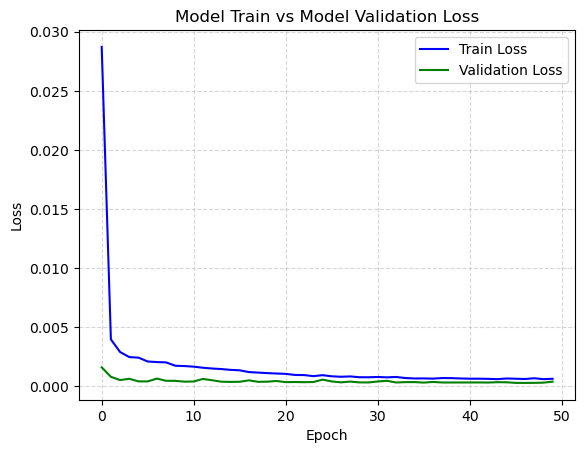

In [56]:
import matplotlib.pyplot as plt

loss = []
loss.extend(history.history['loss'])

# Plot loss
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color = 'green')
plt.title('Model Train vs Model Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.show()

In [57]:
from sklearn.metrics import mean_squared_error
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

mse_train = mean_squared_error(y_train, train_predictions)
mse_test = mean_squared_error(y_test, test_predictions)

print(f"Training MSE: {mse_train}")
print(f"Testing MSE: {mse_test}")


23/23 [==============================] - 0s 7ms/step
Training MSE: 0.000331524022635087
Testing MSE: 0.0003693705963097439


In [58]:
# Calculate the moving average
moving_average = df_stocks['prices'].rolling(window=5).mean()

# Calculate the BIAS
df_stocks['BIAS'] = (df_stocks['prices'] - moving_average) / moving_average

# Delete rows with NaN values
df_stocks = df_stocks.dropna()

df_stocks.head()

,prices,articles,compound,neg,neu,pos,BIAS
2007-01-05,12398,Rise in Ethanol Raises Concerns About Corn as...,-0.9901,0.124,0.794,0.082,-0.004864
2007-01-06,12406,A Status Quo Secretary General. Best Buy and ...,-0.9650,0.134,0.771,0.094,-0.003214
2007-01-07,12414,THE COMMON APPLICATION; Typo.com. Jumbo Bonus...,-0.9975,0.193,0.735,0.072,-0.001641
2007-01-08,12423,VW Group’s Sales Rose Sharply in 2006. Consol...,0.9458,0.097,0.789,0.114,-0.000097
2007-01-09,12416,The Claim: Hot Leftovers Should Cool at Room...,-0.9961,0.108,0.840,0.052,0.000371


In [59]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Selecting prices and compound sentiment scores for simplicity
features = df_stocks[['prices', 'compound','BIAS']].values

# Scaling features
scaler = MinMaxScaler(feature_range=(0, 1, 2))
scaled_features = scaler.fit_transform(features)

In [60]:
def create_sequences(data, time_step=100):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), :])
        y.append(data[i + time_step, 0])  # Assuming 'prices' is at index 0
    return np.array(X), np.array(y)

time_step = 100
X, y = create_sequences(scaled_features, time_step)


In [61]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [62]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Define the LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=500, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/50
45/45 [==============================] - 3s 58ms/step - loss: 0.0190 - val_loss: 5.2198e-04
Epoch 2/50
45/45 [==============================] - 2s 52ms/step - loss: 0.0040 - val_loss: 4.2929e-04
Epoch 3/50
45/45 [==============================] - 3s 56ms/step - loss: 0.0030 - val_loss: 4.4690e-04
Epoch 4/50
45/45 [==============================] - 3s 57ms/step - loss: 0.0028 - val_loss: 7.8339e-04
Epoch 5/50
45/45 [==============================] - 3s 61ms/step - loss: 0.0025 - val_loss: 4.8704e-04
Epoch 6/50
45/45 [==============================] - 2s 55ms/step - loss: 0.0020 - val_loss: 3.8876e-04
Epoch 7/50
45/45 [==============================] - 3s 56ms/step - loss: 0.0019 - val_loss: 4.0665e-04
Epoch 8/50
45/45 [==============================] - 3s 57ms/step - loss: 0.0017 - val_loss: 3.8449e-04
Epoch 9/50
45/45 [==============================] - 3s 57ms/step - loss: 0.0017 - val_loss: 3.7217e-04
Epoch 10/50
45/45 [==============================] - 2s 55ms/step - loss:

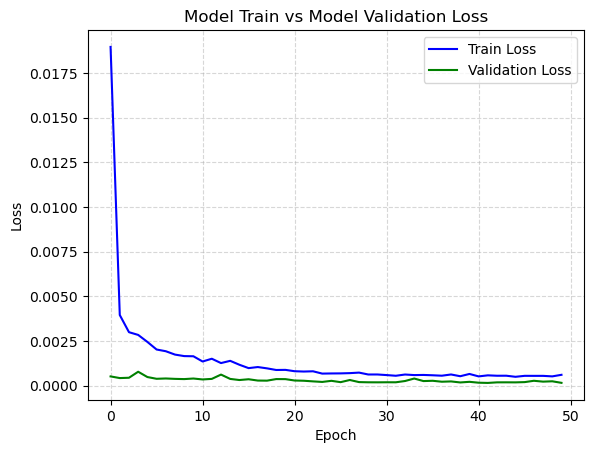

In [63]:
import matplotlib.pyplot as plt

loss = []
loss.extend(history.history['loss'])

# Plot loss
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color = 'green')
plt.title('Model Train vs Model Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.show()

In [64]:
from sklearn.metrics import mean_squared_error
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

mse_train = mean_squared_error(y_train, train_predictions)
mse_test = mean_squared_error(y_test, test_predictions)

print(f"Training MSE: {mse_train}")
print(f"Testing MSE: {mse_test}")


23/23 [==============================] - 0s 8ms/step
Training MSE: 0.00016025533050464307
Testing MSE: 0.0001622313660862646


In [66]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error

Epoch 1/50
45/45 [==============================] - 4s 62ms/step - loss: 0.0419 - val_loss: 0.0019
Epoch 2/50
45/45 [==============================] - 3s 61ms/step - loss: 0.0039 - val_loss: 5.6422e-04
Epoch 3/50
45/45 [==============================] - 3s 59ms/step - loss: 0.0029 - val_loss: 4.0676e-04
Epoch 4/50
45/45 [==============================] - 3s 58ms/step - loss: 0.0024 - val_loss: 6.6651e-04
Epoch 5/50
45/45 [==============================] - 3s 59ms/step - loss: 0.0025 - val_loss: 3.6454e-04
Epoch 6/50
45/45 [==============================] - 3s 62ms/step - loss: 0.0022 - val_loss: 3.7565e-04
Epoch 7/50
45/45 [==============================] - 3s 62ms/step - loss: 0.0021 - val_loss: 5.0998e-04
Epoch 8/50
45/45 [==============================] - 3s 63ms/step - loss: 0.0019 - val_loss: 3.9219e-04
Epoch 9/50
45/45 [==============================] - 3s 60ms/step - loss: 0.0020 - val_loss: 4.2384e-04
Epoch 10/50
45/45 [==============================] - 3s 60ms/step - loss: 0.0

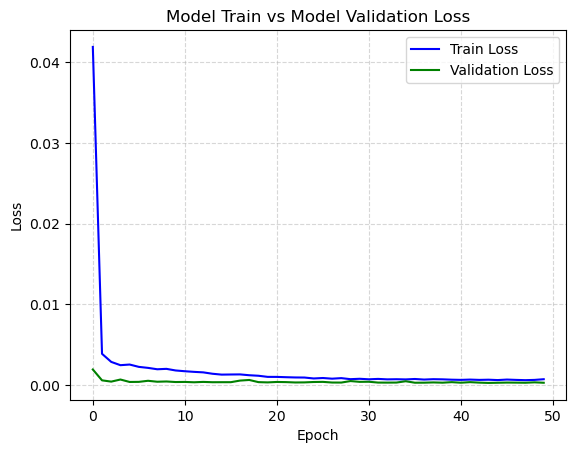

23/23 [==============================] - 0s 7ms/step
Epoch 1/50
45/45 [==============================] - 4s 58ms/step - loss: 0.0259 - val_loss: 0.0013
Epoch 2/50
45/45 [==============================] - 2s 55ms/step - loss: 0.0039 - val_loss: 6.3075e-04
Epoch 3/50
45/45 [==============================] - 2s 55ms/step - loss: 0.0032 - val_loss: 5.3227e-04
Epoch 4/50
45/45 [==============================] - 2s 54ms/step - loss: 0.0028 - val_loss: 4.4289e-04
Epoch 5/50
45/45 [==============================] - 3s 56ms/step - loss: 0.0025 - val_loss: 3.5462e-04
Epoch 6/50
45/45 [==============================] - 3s 60ms/step - loss: 0.0024 - val_loss: 5.8055e-04
Epoch 7/50
45/45 [==============================] - 3s 59ms/step - loss: 0.0022 - val_loss: 3.8003e-04
Epoch 8/50
45/45 [==============================] - 3s 58ms/step - loss: 0.0020 - val_loss: 4.4215e-04
Epoch 9/50
45/45 [==============================] - 2s 55ms/step - loss: 0.0018 - val_loss: 4.0982e-04
Epoch 10/50
45/45 [=====

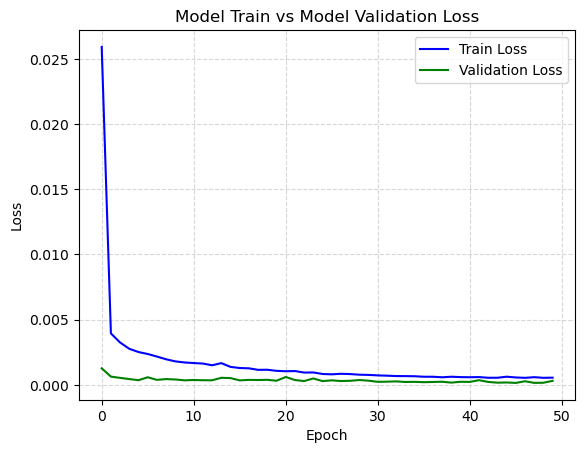

23/23 [==============================] - 0s 7ms/step
Epoch 1/50
45/45 [==============================] - 3s 56ms/step - loss: 0.0279 - val_loss: 5.3070e-04
Epoch 2/50
45/45 [==============================] - 2s 51ms/step - loss: 0.0048 - val_loss: 3.3218e-04
Epoch 3/50
45/45 [==============================] - 2s 52ms/step - loss: 0.0033 - val_loss: 4.2191e-04
Epoch 4/50
45/45 [==============================] - 2s 52ms/step - loss: 0.0026 - val_loss: 3.9387e-04
Epoch 5/50
45/45 [==============================] - 2s 52ms/step - loss: 0.0026 - val_loss: 6.5010e-04
Epoch 6/50
45/45 [==============================] - 2s 53ms/step - loss: 0.0023 - val_loss: 3.4920e-04
Epoch 7/50
45/45 [==============================] - 2s 52ms/step - loss: 0.0020 - val_loss: 3.5353e-04
Epoch 8/50
45/45 [==============================] - 2s 52ms/step - loss: 0.0018 - val_loss: 3.6124e-04
Epoch 9/50
45/45 [==============================] - 2s 53ms/step - loss: 0.0018 - val_loss: 4.5076e-04
Epoch 10/50
45/45 [=

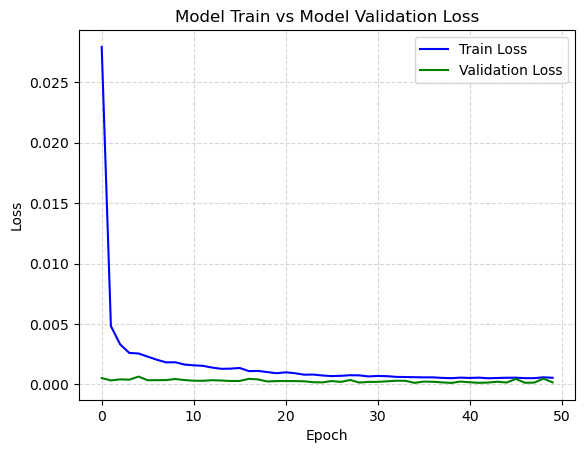

23/23 [==============================] - 0s 7ms/step
Epoch 1/50
45/45 [==============================] - 4s 60ms/step - loss: 0.0372 - val_loss: 0.0015
Epoch 2/50
45/45 [==============================] - 3s 57ms/step - loss: 0.0043 - val_loss: 5.9149e-04
Epoch 3/50
45/45 [==============================] - 3s 57ms/step - loss: 0.0030 - val_loss: 3.6538e-04
Epoch 4/50
45/45 [==============================] - 3s 58ms/step - loss: 0.0027 - val_loss: 5.4479e-04
Epoch 5/50
45/45 [==============================] - 3s 59ms/step - loss: 0.0025 - val_loss: 3.8099e-04
Epoch 6/50
45/45 [==============================] - 3s 59ms/step - loss: 0.0023 - val_loss: 4.5560e-04
Epoch 7/50
45/45 [==============================] - 3s 59ms/step - loss: 0.0022 - val_loss: 3.5079e-04
Epoch 8/50
45/45 [==============================] - 3s 58ms/step - loss: 0.0020 - val_loss: 3.5809e-04
Epoch 9/50
45/45 [==============================] - 3s 57ms/step - loss: 0.0018 - val_loss: 3.7142e-04
Epoch 10/50
45/45 [=====

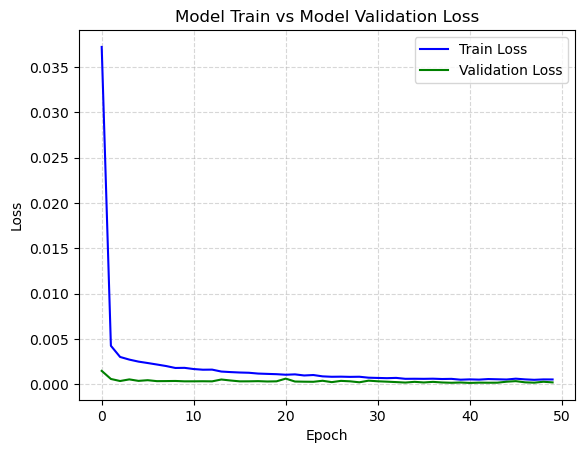

23/23 [==============================] - 0s 7ms/step
Epoch 1/50
45/45 [==============================] - 4s 60ms/step - loss: 0.0267 - val_loss: 9.7843e-04
Epoch 2/50
45/45 [==============================] - 2s 54ms/step - loss: 0.0036 - val_loss: 5.6161e-04
Epoch 3/50
45/45 [==============================] - 3s 57ms/step - loss: 0.0029 - val_loss: 7.0970e-04
Epoch 4/50
45/45 [==============================] - 3s 56ms/step - loss: 0.0028 - val_loss: 5.6372e-04
Epoch 5/50
45/45 [==============================] - 3s 56ms/step - loss: 0.0025 - val_loss: 5.5030e-04
Epoch 6/50
45/45 [==============================] - 3s 57ms/step - loss: 0.0025 - val_loss: 8.2092e-04
Epoch 7/50
45/45 [==============================] - 3s 56ms/step - loss: 0.0026 - val_loss: 8.4389e-04
Epoch 8/50
45/45 [==============================] - 2s 55ms/step - loss: 0.0021 - val_loss: 5.0975e-04
Epoch 9/50
45/45 [==============================] - 2s 55ms/step - loss: 0.0021 - val_loss: 6.9960e-04
Epoch 10/50
45/45 [=

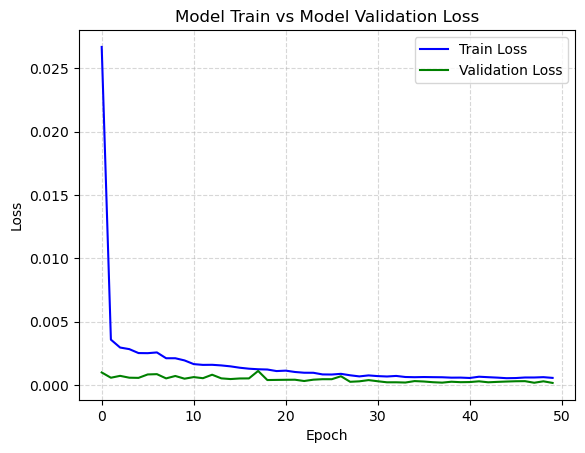

23/23 [==============================] - 0s 7ms/step
Training MSE: [0.00023955266190989435, 0.00029876353753904844, 0.00017402747228612277, 0.00018664064691580756, 0.00014401094041039804]
Testing MSE: [0.00026510650064022023, 0.00030589291177863343, 0.00017262606550352903, 0.0002129916236260712, 0.00015133074265076172]


In [67]:
window_sizes = range(1, 6)
mse_train = []
mse_test = []

for window in window_sizes:
    # Calculate the moving average
    moving_average = df_stocks['prices'].rolling(window=window).mean()

    # Calculate the BIAS
    df_stocks['BIAS'] = (df_stocks['prices'] - moving_average) / moving_average

    # Delete rows with NaN values
    df_stocks = df_stocks.dropna()
    

    # Selecting prices and compound sentiment scores for simplicity
    features = df_stocks[['prices', 'compound','BIAS']].values

    # Scaling features
    scaler = MinMaxScaler(feature_range=(0, 1, 2))
    scaled_features = scaler.fit_transform(features)
    
    def create_sequences(data, time_step=100):
        X, y = [], []
        for i in range(len(data) - time_step - 1):
            X.append(data[i:(i + time_step), :])
            y.append(data[i + time_step, 0])  # Assuming 'prices' is at index 0
        return np.array(X), np.array(y)

    time_step = 100
    X, y = create_sequences(scaled_features, time_step)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Define the LSTM model
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
        Dropout(0.2),
        LSTM(50, return_sequences=False),
        Dropout(0.2),
        Dense(25),
        Dense(1)
    ])

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model
    history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test))
    
    loss = []
    loss.extend(history.history['loss'])

    plt.plot(history.history['loss'], label='Train Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Validation Loss', color = 'green')
    plt.title('Model Train vs Model Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()
    plt.show()

    train_predictions = model.predict(X_train)
    test_predictions = model.predict(X_test)
    
    mse_train.append(mean_squared_error(y_train, train_predictions))
    mse_test.append(mean_squared_error(y_test, test_predictions))
    
print(f"Training MSE: {mse_train}")
print(f"Testing MSE: {mse_test}")